In [1]:
from pyopenms import *
import matplotlib.pyplot as plt

In [7]:
protein_ids = []
peptide_ids = []
SimpleSearchEngineAlgorithm().search("Fusion_180220_08.mzML", "Scerevisiae_UPS2_1802.fasta", protein_ids, peptide_ids)

In [8]:
exp = MSExperiment()
MzMLFile().load("Fusion_180220_08.mzML", exp)
filtered = MSExperiment()
for s in exp:
    if s.getMSLevel() == 2:
        filtered.addSpectrum(s)

In [9]:
def mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title):
            obs_int = [element / max(obs_int) for element in obs_int] # relative intenstiy
            theo_int = [element * -1 for element in theo_int] # invert the intensity for the mirror plot
            plt.figure(figsize=(12,8))
            plt.bar(obs_mz, obs_int, width = 3.0)
            plt.bar(theo_mz, theo_int, width = 3.0)
            plt.title(title)
            plt.ylabel('intensity')
            plt.xlabel('m/z')

Peptide scan index: 30
Peptide ID m/z: 777.789916992188
 - Peptide hit rank: 1
 - Peptide hit sequence: SANNNEENSDC(Carbamidomethyl)GDK
 - Peptide hit score: 0.0017323700012639165
Number of matched peaks: 13
ion	theo. m/z	observed m/z
y5++	2	SANNNEENSDC(Carbamidomethyl)GDK	297.613041390021	297.98919677734375
b7++	2	SANNNEENSDC(Carbamidomethyl)GDK	380.14883463667104	380.60845947265625
y9++	2	SANNNEENSDC(Carbamidomethyl)GDK	527.1931142887711	526.76025390625
y11++	2	SANNNEENSDC(Carbamidomethyl)GDK	641.2360424801711	641.2774658203125
b12++	2	SANNNEENSDC(Carbamidomethyl)GDK	646.725841932321	646.976318359375
y6+	1	SANNNEENSDC(Carbamidomethyl)GDK	681.250835472771	681.531982421875
y12++	2	SANNNEENSDC(Carbamidomethyl)GDK	698.2575065758712	698.5079956054688
b13++	2	SANNNEENSDC(Carbamidomethyl)GDK	704.2393140120711	703.8626708984375
y7+	1	SANNNEENSDC(Carbamidomethyl)GDK	795.293763664171	795.212646484375
y10+	1	SANNNEENSDC(Carbamidomethyl)GDK	1167.421880302171	1167.421630859375
b11+	1	SANNNEENSDC(

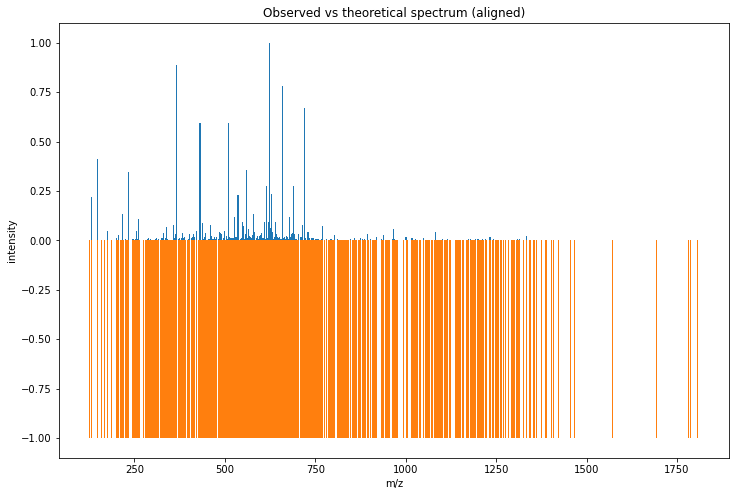

In [10]:
# Peptide identification values
theo_mz, theo_int, obs_mz, obs_int = [], [], [], []
for peptide_id in peptide_ids[:100]:
    print (35*"=")
    print ("Peptide scan index:", peptide_id.getMetaValue("scan_index"))
    print ("Peptide ID m/z:", peptide_id.getMZ())
  # PeptideHits
    for hit in peptide_id.getHits():
        print(" - Peptide hit rank:", hit.getRank())
        print(" - Peptide hit sequence:", hit.getSequence())
        print(" - Peptide hit score:", hit.getScore())
        
        spectra = filtered.getSpectrum(peptide_id.getMetaValue("scan_index"))
        tsg = TheoreticalSpectrumGenerator()
        thspec = MSSpectrum()
        p = Param()
        p.setValue("add_metainfo", "true")
        tsg.setParameters(p)
        peptide = AASequence.fromString(hit.getSequence().toString())
        tsg.getSpectrum(thspec, peptide, 1, 2)
        
        # Spectrum alignment
        alignment = []
        spa = SpectrumAlignment()
        p = spa.getParameters()
        
        p.setValue("tolerance", 0.5)
        p.setValue("is_relative_tolerance", "false")
        spa.setParameters(p)

        spa.getSpectrumAlignment(alignment, thspec, spectra)

        print("Number of matched peaks: " + str(len(alignment)))
        print("ion\ttheo. m/z\tobserved m/z")
        for theo_idx, obs_idx in alignment:
            ion_name = thspec.getStringDataArrays()[0][theo_idx].decode()
            ion_charge = thspec.getIntegerDataArrays()[0][theo_idx]
            print(ion_name + "\t" + str(ion_charge) + "\t"
                  +peptide.toString()+"\t"+ str(thspec[theo_idx].getMZ())
                  + "\t" + str(spectra[obs_idx].getMZ()))

        
        for theo_idx, obs_idx in alignment:
            theo_mz.append(thspec[theo_idx].getMZ())
            theo_int.append(thspec[theo_idx].getIntensity())
            obs_mz.append(spectra[obs_idx].getMZ())
            obs_int.append(spectra[obs_idx].getIntensity())
title = 'Observed vs theoretical spectrum (aligned)'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)